# 5. Forward modeling of point sources

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.0* onwards  
> Last update: *2022/03/23*

**Table of contents**

* [5.1. Loading ADI data](#1.-Loading-ADI-data)

* [5.2. Generating and injecting synthetic planets](#5.2.-Generating-and-injecting-synthetic-planets)
 
* [5.3. Flux and position estimation with NEGFC](#5.3.-Flux-and-position-estimation-with-NEGFC)
    - [5.3.1. Nelder-Mead based optimization](#5.3.1.-Nelder-Mead-based-optimization)
    - [5.3.2. Planet subtraction](#5.3.2.-Planet-subtraction)
    - [5.3.3. NEGFC technique coupled with MCMC](#5.3.3.-NEGFC-technique-coupled-with-MCMC)
        - [5.3.3.1. Running the MCMC sampler](#5.3.3.1.-Running-the-MCMC-sampler)
        - [5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots](#5.3.3.2.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [5.3.3.3. Highly probable values and confidence intervals](#5.3.3.3.-Highly-probable-values-and-confidence-intervals)
    - [5.3.4. Residual speckle uncertainty](#5.3.4.-Residual-speckle-uncertainty)
    - [5.3.5. Final uncertainties](#5.3.5.-Final-uncertainties)

This tutorial shows:

- how to generate and inject fake companions in a cube;
- how to estimate the astrometry and photometry of a directly imaged companion, and associated uncertainties.

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we import all the VIP routines that will be used in this tutorial.
The path to some routines has changed between versions 1.0.3 and 1.1.0, which saw a major revamp of the modular architecture, hence the `if` statements.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import VLT_NACO
    from vip_hci.metrics import cube_inject_companions
    from vip_hci.negfc import (confidence, firstguess, mcmc_negfc_sampling, show_corner_plot, show_walk_plot,
                               speckle_noise_uncertainty)
    from vip_hci.pca import pca, pca_annular, pca_annulus, pca_grid
else:
    from vip_hci.config import VLT_NACO
    from vip_hci.fm import (confidence, cube_inject_companions, cube_planet_free, firstguess, mcmc_negfc_sampling, 
                            normalize_psf, show_corner_plot, show_walk_plot, speckle_noise_uncertainty)
    from vip_hci.psfsub import median_sub, pca, pca_annular, pca_annulus, pca_grid
    
# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import contrast_curve, detection, significance, snr, snrmap, throughput
from vip_hci.preproc import frame_crop
from vip_hci.var import fit_2dgaussian, frame_center

VIP version:  1.1.0


## 5.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO coronagraphic (VORTEX AGPM) dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract). The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the data:

In [3]:
psfnaco = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_pa.fits'

cube = open_fits(cubename)
psf = open_fits(psfnaco)
pa = open_fits(angname)

Fits HDU-0 data successfully loaded. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded. Data shape: (39, 39)
Fits HDU-0 data successfully loaded. Data shape: (61,)


In [4]:
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)

angs = pa+derot_off+TN

Let's measure the FWHM by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF:

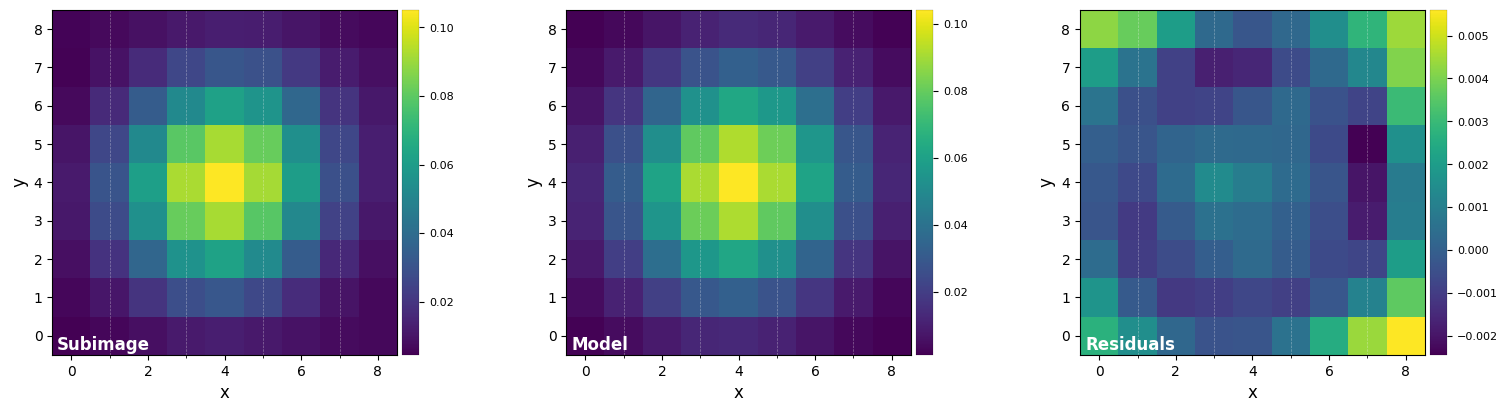

FWHM_y = 4.733218722257407
FWHM_x = 4.473682405059958 

centroid y = 19.006680059041216
centroid x = 18.999424475165455
centroid y subim = 4.006680059041214
centroid x subim = 3.9994244751654535 

amplitude = 0.10413004853269707
theta = -34.08563676836685


In [5]:
%matplotlib inline
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [6]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.603450563658683


Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [7]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


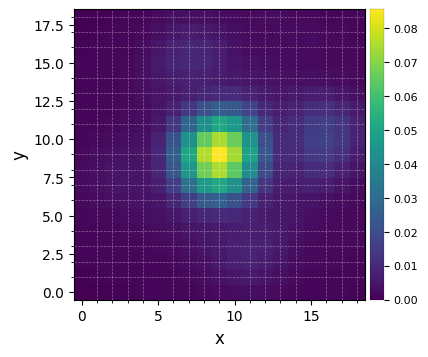

In [8]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `conf` subpackage:

In [9]:
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


[Go to the top](#Table-of-contents)

## 5.2. Generating and injecting synthetic planets

We first select `imlib` and associated `interpolation` order. 'vip-fft' is more accurate, but 'skimage is faster, and 'opencv' even faster - see `Tutorial 7`. In order to , it is highly recommended to have `opencv` installed (optional dependency of `VIP`, i.e. to be installed manually).

In [10]:
try:
    import cv2
    imlib_rot = 'opencv'
    interpolation = 'lanczos4'
except:
    imlib_rot = 'skimage' #'vip-fft'
    interpolation='biquintic' #None   

The `cube_inject_companions` function in the `fm` module (VIP versions >= 1.1.0) makes the injection of fake companions at arbitrary fluxes and locations very easy. The normalized non-coronagraphic PSF should be provided for the injection. If the user does not have access to an observed PSF, the `create_synth_psf` from the `var` module can be used to create synthetic ones (based on 2D Gaussian, Moffat or Airy models).

Some procedures, e.g. the negative fake companion technique and the contrast curve generation, heavily rely on the injection of fake companions. The coordinates for the injection are provided in the *derotated* image, while the actual injection occurs in the images of the input cube, i.e. in the *rotated* field.

In [11]:
rad_fc = 30.5
theta_fc = 240
flux_fc = 400.
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=flux_fc, plsc=pxscale_naco, 
                                rad_dists=[rad_fc], theta=theta_fc, n_branches=1, 
                                imlib=imlib_rot, interpolation=interpolation)


Branch 1:
	(X,Y)=(34.75, 23.59) at 0.83 arcsec (30.50 pxs from center)


Let's set the corresponding cartesian coordinates:

In [12]:
cy, cx = frame_center(cube[0])
x_fc = cx + rad_fc*np.cos(np.deg2rad(theta_fc))
y_fc = cy + rad_fc*np.sin(np.deg2rad(theta_fc))

xy_test = (x_fc, y_fc)
print('({:.1f}, {:.1f})'.format(xy_test[0],xy_test[1]))

(34.7, 23.6)


Let's double-check the fake companion was injected at the right location, by post-processing the cube and checking the final image. Let's use PCA, and infer the optimal $n_{\rm pc}$ while we are at it - this will be useful for the next section.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-23 15:49:16
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.016892
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 41
Optimal number of PCs = 10, for S/N=13.357
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 34.7, 23.6
Flux in a centered 1xFWHM circular aperture = 104.699
Central pixel S/N = 18.148
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 13.357
Max S/N (shifting the aperture center) = 18.449
stddev S/N (shifting the aperture center) = 4.067



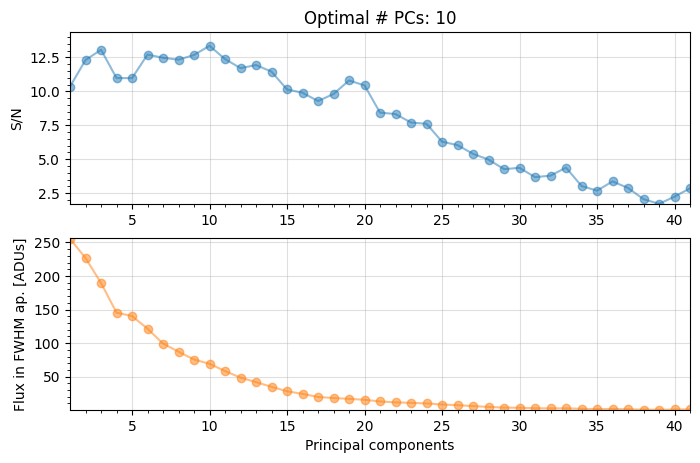

In [13]:
res_ann_opt = pca_grid(cubefc, angs, fwhm=fwhm_naco, range_pcs=(1,41,1), source_xy=xy_test, mode='annular',
                       annulus_width=4*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True)

The grid search looking for the optimal number of principal components (npc) found that 10 principal components maximizes the S/N ratio of the injected fake companion. 

In [14]:
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

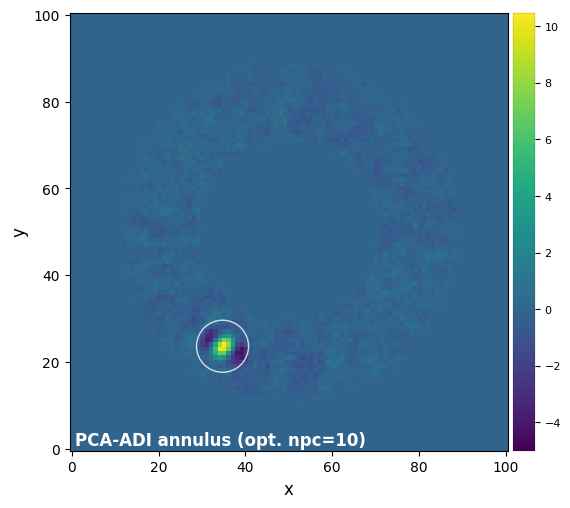

In [15]:
plot_frames(final_ann_opt, label='PCA-ADI annulus (opt. npc={:.0f})'.format(opt_npc_ann),
            dpi=100, vmin=-5, colorbar=True, circle=xy_test)

We can see that the fake companion was indeed injected at the requested location.

[Go to the top](#Table-of-contents)

## 5.3. Flux and position estimation with NEGFC

When a companion candidate is detected, the next step is to characterize it, i.e. infer its exact position (astrometry) and flux (photometry). 

<font color=orange> **Question 5.1**: Why would a simple 2D Gaussian fit (as performed e.g. for the stellar PSF in Section 5.1) be inappropriate to extract the astrometry and photometry of a candidate companion? </font>

`VIP` implements the Negative fake companion (NEGFC) technique for robust extraction of the position and flux of detected point-like sources. The technique can be summarized as follow (see full description in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract)):

1) Estimate the position and flux of the planet, from either the visual inspection of reduced images or a previous estimator (see ABC below).

2) Scale (in flux) and shift the normalized off-axis PSF to remove the estimate from the input data cube.

3) Process the cube with PCA in a single annulus encompassing the point source.

4) Measure residuals in an aperture centered on the approximate location of the companion candidate.

5) Iterate on the position and flux of the injected negative PSF (steps 2-4), until the absolute residuals in the aperture are minimized (i.e. the injected negative companion flux and the position match exactly that of the true companion).

Iterations between steps 2-4 can be performed in one of 3 ways - sorted in increasing computation time and accuracy: 

A) a grid search on the flux only, provided a fixed estimate of the position (implemented in the `firstguess` function);

B) a Nelder-Mead simplex algorithm (`firstguess` function with the `simplex=True` option);

C) an MCMC sampler, which has the advantage to also yield uncertainties on each of the parameters of the point source (`mcmc_negfc_sampling` function).

Different figures of merit can be used for minimization of the residuals ([Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract); [Christiaens et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6117C/abstract)):
$$\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}~~({\rm default}), ~~~~~~~~\chi^2 = \sum_j^N |I_j|, ~~~~~~~~\chi^2 = N {\rm std}(I_j).$$

where $j \in {1,...,N}$, $N$ is the total number of pixels contained in the circular aperture around the companion candidate, $\mu$ and $\sigma$ are the mean and standard deviation ($N_{\rm resel}$ degrees of freedom) of pixel intensities in a truncated annulus at the radius of the companion candidate, but avoiding the azimuthal region encompassing the negative side lobes.

[Go to the top](#Table-of-contents)

### 5.3.1. Nelder-Mead based optimization

With the function `firstguess`, we can obtain a first estimation of the flux and position by running A) a naive grid minimization (grid of values for the flux through parameter `f_range`), and B) a Nelder-mead based minimization (if the parameter `simplex` is set to *True*). The latter is done based on the preliminary guess of the grid minimization. The maximum number of iterations and error can be set with the parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

Fisrt we define the position of the sources by examining a flux frame or S/N map. `planets_xy_coord` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)). Let's take the coordinates of the previously injected companion.

Let's test the algorithm with different values for the # of PCs: 5 and 25.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-23 15:49:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   545.902
2/30   0.149   545.844
3/30   0.221   545.757
4/30   0.329   545.629
5/30   0.489   545.439
6/30   0.728   545.154
7/30   1.083   544.728
8/30   1.610   544.096
9/30   2.395   543.161
10/30   3.562   541.764
11/30   5.298   539.682
12/30   7.880   536.498
13/30   11.721   531.845
14/30   17.433   525.036
15/30   25.929   514.261
16/30   38.566   497.811
17/30   57.362   473.843
18/30   85.317   440.493
19/30   126.896   392.708
20/30   188.739   319.134
21/30   

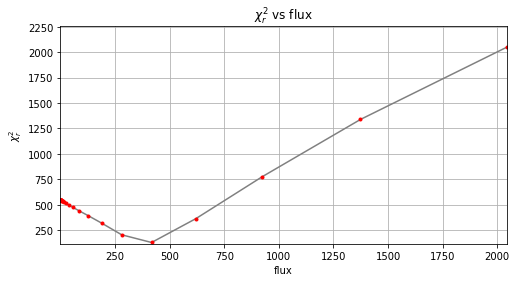

Planet 0: preliminary guess: (r, theta, f)=(30.5, 240.0, 417.5)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 94, nfev: 214, chi2r: 108.73934936523438
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.528, 239.942, 384.592) at 
          (X,Y)=(34.71, 23.58)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:26.309834
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [16]:
r_lo, theta_lo, f_lo = firstguess(cubefc, angs, psfn, ncomp=5, plsc=pxscale_naco,
                                  planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                                  f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                                  simplex=True, imlib=imlib_rot, interpolation=interpolation,
                                  plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-23 15:49:46
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   72.406
2/30   0.149   72.406
3/30   0.221   72.405
4/30   0.329   72.406
5/30   0.489   72.407
6/30   0.728   72.407
7/30   1.083   72.404
8/30   1.610   72.393
9/30   2.395   72.382
10/30   3.562   72.354
11/30   5.298   72.324
12/30   7.880   72.243
13/30   11.721   72.027
14/30   17.433   71.693
15/30   25.929   71.409
16/30   38.566   71.149
17/30   57.362   70.735
18/30   85.317   68.718
19/30   126.896   64.258
20/30   188.739   58.907
21/30   280.722   49.760
22/

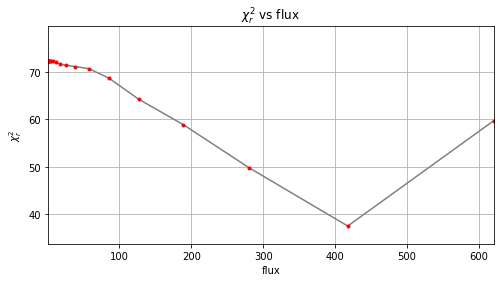

Planet 0: preliminary guess: (r, theta, f)=(30.5, 240.0, 417.5)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 71, nfev: 183, chi2r: 36.07411193847656
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.284, 239.908, 419.466) at 
          (X,Y)=(34.82, 23.80)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:20.901954
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [17]:
r_hi, theta_hi, f_hi = firstguess(cubefc, angs, psfn, ncomp=25, plsc=pxscale_naco,
                                  planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                                  f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                                  imlib=imlib_rot, interpolation=interpolation, simplex=True, 
                                  plot=True, verbose=True)

For both the $n_{\rm pc} = 5$ and $n_{\rm pc} = 25$ cases, the parameters estimated by the Nelder-Mead optimization are not exactly equal to the original values (radius=30.5, theta=240, flux=400), which reflects:
- the limitations of this heuristic minization procedure (depending on the initial guess the minimization may get trapped in a different local minimum);
- the higher residual speckle noise level in images obtained with low $n_{\rm pc}$ values; 
- the higher self-subtraction for high $n_{\rm pc}$ values.

These estimates are provided without uncertainties (error bars). We will come back to this question later on. 

For comparison, let's use the optimal $n_{\rm pc} = 10$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-23 15:50:07
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   292.865
2/30   0.149   292.834
3/30   0.221   292.788
4/30   0.329   292.721
5/30   0.489   292.624
6/30   0.728   292.478
7/30   1.083   292.260
8/30   1.610   291.953
9/30   2.395   291.534
10/30   3.562   290.891
11/30   5.298   289.864
12/30   7.880   288.369
13/30   11.721   286.490
14/30   17.433   283.611
15/30   25.929   279.237
16/30   38.566   273.580
17/30   57.362   264.995
18/30   85.317   248.325
19/30   126.896   223.977
20/30   188.739   185.448
21/30   

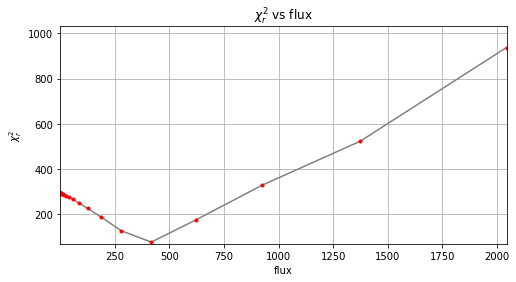

Planet 0: preliminary guess: (r, theta, f)=(30.5, 240.0, 417.5)
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 114, nfev: 256, chi2r: 67.40306091308594
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.531, 239.900, 390.977) at 
          (X,Y)=(34.69, 23.59)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:28.631111
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [18]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=opt_npc_ann, plsc=pxscale_naco,
                               planets_xy_coord=[xy_test], fwhm=fwhm_naco, 
                               f_range=None, annulus_width=4*fwhm_naco, aperture_radius=2,
                               imlib=imlib_rot, interpolation=interpolation, simplex=True, 
                               plot=True, verbose=True)

We see that using the optimal $n_{\rm pc}$ leads to a closer parameter estimates to the ground truth.

<font color=green> **Answer 5.1**: If relying on a 2D Gaussian fit, both the photometry and astrometry would be biased by self-subtraction and the negative side lobes. </font>

[Go to the top](#Table-of-contents)

### 5.3.2. Planet subtraction

Let's use the values obtained with the simplex optimization to subtract the planet with the function `cube_planet_free`.

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [19]:
plpar_fc = [(r_0[0], theta_0[0], f_0[0])]

Note: r_0, theta_0 and f_0 have the same length as the number of planet coordinates `planets_xy_coord` provided to `firstguess`. Here there is only one planet, so we take the zeroth index. The number of tuples in (i.e the length of) `plpar_fc` should match the number of planets.

In [20]:
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)

Let's double-check the fake companion was well removed by computing a PCA post-processed image:

In [21]:
from vip_hci.preproc import cube_derotate
from vip_hci.config import time_ini, timing
t0 = time_ini()
for i in range(100):
    fr_pca_emp = pca_annulus(cube_emp, angs, ncomp=opt_npc_ann, annulus_width=4*fwhm_naco, 
                             r_guess=rad_fc, imlib=imlib_rot, interpolation=interpolation)
    #cube_tmp = cube_derotate(cube_emp, angs, imlib=imlib_rot, interpolation=interpolation, edge_blend='')
timing(t0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-23 15:50:36
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:06.078157
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

In [22]:
cropped_frame1 = frame_crop(final_ann_opt, cenxy=xy_test, size=15)

New shape: (15, 15)


In [23]:
cropped_frame2 = frame_crop(fr_pca_emp, cenxy=xy_test, size=15)

New shape: (15, 15)


Let's use both `'mode=surface'` and the default image mode of `plot_frames` to show the residuals in the vicinity of the companion:

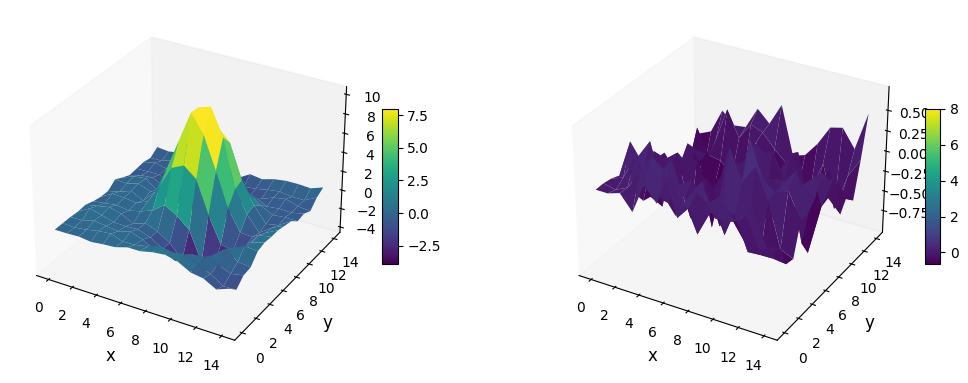

In [24]:
plot_frames((cropped_frame1, cropped_frame2), mode='surface', vmax=8)

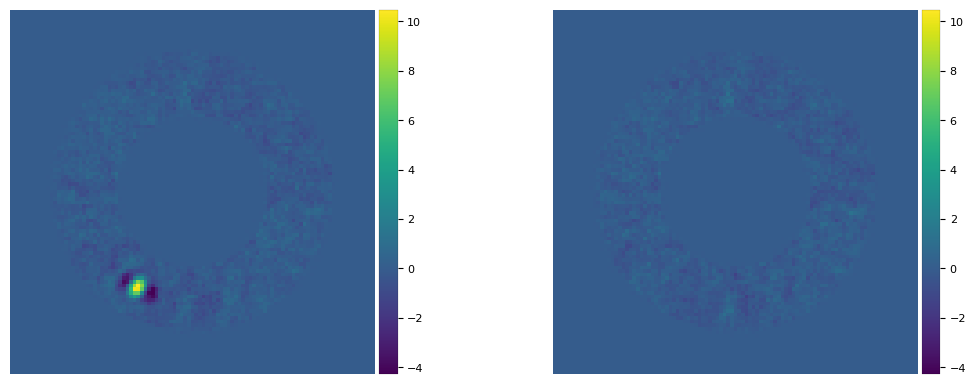

In [25]:
plot_frames((final_ann_opt, fr_pca_emp), vmin = float(np.amin(final_ann_opt)), 
            vmax= float(np.amax(final_ann_opt)), axis=False)

Not only the bright point-like signal is subtracted, but so are the negative side lobes. A subtraction not leaving any significant artifact/defect is a good sign that the inferred parameters are correct. However, keep in mind that even for slightly inaccurate parameters, the final image can still look relatively clean. Let's take for example the parameters inferred with non-optimal $n_{\rm pc}$: 

[(30.528002420694463, 239.9423851010544, 384.5923529117857)]


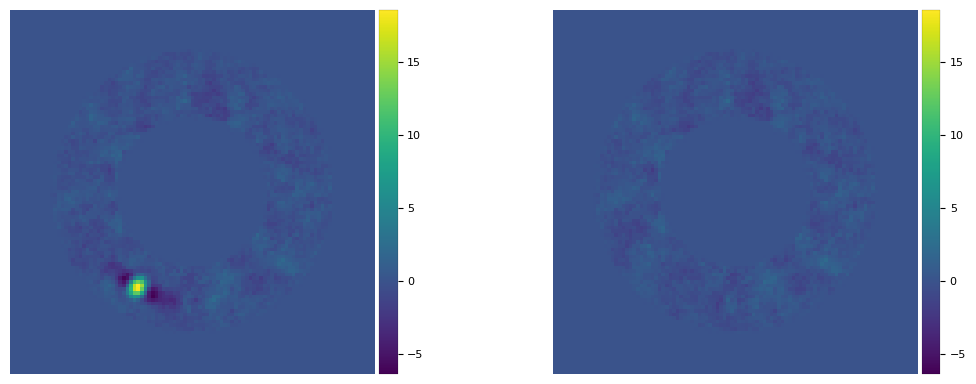

In [26]:
# planet parameters inferred from npc=5 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_lo[0], theta_lo[0], f_lo[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)
final_ann_5 = pca_annulus(cubefc, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp5 = pca_annulus(cube_emp, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_5, fr_pca_emp5), vmin = float(np.amin(final_ann_5)), 
            vmax= float(np.amax(final_ann_5)), axis=False)

[(30.284188790167416, 239.9081741196906, 419.4655631030056)]


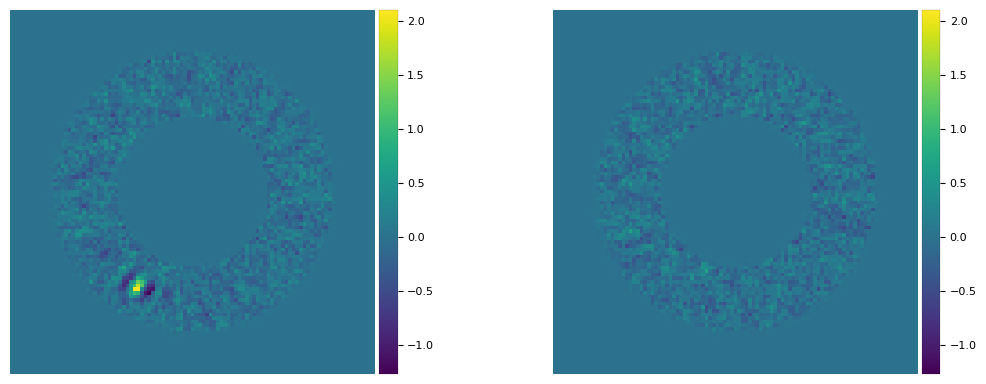

In [27]:
# parameters inferred from npc=25 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_hi[0], theta_hi[0], f_hi[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, pxscale_naco, imlib=imlib_rot, 
                            interpolation=interpolation)
final_ann_25 = pca_annulus(cubefc, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp25 = pca_annulus(cube_emp, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_25, fr_pca_emp25), vmin = float(np.amin(final_ann_25)), 
            vmax= float(np.amax(final_ann_25)), axis=False)

Inaccurate parameters still leading to an apparently good removal of the companion brings the question of the uncertainties on each of the three parameters characterizing the companion. The next sections are dedicated to this question. 

[Go to the top](#Table-of-contents)

### 5.3.3. NEGFC technique coupled with MCMC

#### 5.3.3.1. Running the MCMC sampler

MCMC is a more robust way of obtaining the flux and position. It samples the posterior distributions of the parameters and from them we can infer both the most likely parameter values and uncertainties on each parameter. The relevant function is `mcmc_negfc_sampling`, which can accept a number of parameters. Let's define them in the next few boxes:

Let's first define observation-related parameters, such as the non-coronagraphic psf, its FWHM and the pixel scale od the detector: 

In [28]:
obs_params = {'psfn': psfn,
              'fwhm': fwhm_naco,
              'plsc': pxscale_naco}

In NEGFC, PCA in a single annulus is used by default to speed up the algorithm - although other algorithms can be used through the `algo` parameter. Let's set the $n_{\rm pc}$ to the optimal $n_{\rm pc}$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets). We set the width of the annulus on which PCA is performed (in pixels) with the `annulus_width` parameter. We also set a few other algorithm-related parameters in the following box:

In [29]:
annulus_width = 4*fwhm_naco

algo_params = {'algo': pca_annulus,
               'ncomp': opt_npc_ann,
               'annulus_width': annulus_width,
               'svd_mode': 'lapack',
               'imlib': imlib_rot, 
               'interpolation': interpolation}

The choice of log-likelihood expression to be used is determined by `mu_sigma` and `fm`. If the former is True (default; mu and sigma calculated automatically) or a tuple of 2 values, the following figure of merit will be used: $\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}$. Otherwise, the choice will be determined by `fm`: 'sum' for the sum of absolute residuals, or 'stddev' for the standard deviation of residuals (which can be useful if the point source is contained within a more extended signal).
`aperture_radius` is the radius of the aperture  (in `fwhm` units) in which the residual intensities $I_j$ are considered.

In [30]:
mu_sigma=True
aperture_radius=2

negfc_params = {'mu_sigma': mu_sigma,
                'aperture_radius': aperture_radius}

Parameter ``initial_state`` corresponds to the initial first estimation of the planets parameters (r, theta, flux). We set it to the result of the simplex optimization, obtained with optimal $n_{\rm pc}$. Note that the MCMC minimization can only run for one companion candidate at a time, hence the first dimension of init should always be 3 (not the number of planets, as opposed to `planets_xy_coord` in `firstguess`).

In [31]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Beware that the MCMC procedure is a CPU intensive procedure and can take several hours when run properly on a standard laptop. We use the affine invariant sampler from `emcee` which can be run in parallel (`nproc` sets the number of CPUs to be used). At least 100 walkers are recommended for our MCMC chain, although both the number of walkers and iterations will depend on your dataset. 
For the sake of preventing this tutorial to take too long to run, we set the maximum number of iterations to 500, although feel free to significantly increase it in case of non-convergence.

In [32]:
nwalkers, itermin, itermax = (100, 200, 500)

mcmc_params = {'nwalkers': nwalkers,
               'niteration_min': itermin,
               'niteration_limit': itermax,
               'bounds': None,
               'nproc': 2}


Another update from Christiaens et al. (2021) is that the convergence can now be evaluated based on the auto-correlation time (see more details in the [documentation of `emcee`](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)), instead of the Gelman-Rubin test, which is inappropriate for non-independent samples (such as an MCMC chain).
We set the convergence test to the autocorrelation time based criterion using `conv_test='ac'` (instead of Gelman-Rubin 'gb'). We also set the autocorrelation criterion $N/\tau >= a_c$, where $N$ is the number of samples and $\tau$ the autocorrelation time, to `ac_c=50` (the value recommended in the `emcee` documentation). Finally, we set the number of consecutive times the criterion must be met to: `ac_count_thr=1`, and the maximum gap in number of steps between 2 checks of the convergence criterion to: `check_maxgap=50`. If the maximum number of iterations `niteration_limit` is large enough, the chain will stop upon meeting the convergence criterion (spoiler: it won't be the case here since we chose a small value for `niteration_limit`).

In [33]:
conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr': ac_count_thr,
               'check_maxgap': check_maxgap}

Setting `bounds=None` does *not* mean no bounds are used for parameter exploration, but rather that they are set automatically to:
- $r \in [r_0-w_{ann}/2, r_0+w_{ann}/2]$, where $w_{ann}$ is the `annulus_width`,
- $\theta \in [\theta_0-\Delta {\rm rot}, \theta_0+\Delta {\rm rot}]$, where $\Delta {\rm rot}$ is the angle subtended by min(`aperture_radius`/2,`fwhm`) at $r_0$,
- $f \in [0.1*f_0, 2*f_0]$,

where ($r_0, \theta_0, f_0$) = `initial_state`.
If the `bounds` are provided manually (as a tuple of tuples), they will supersede the automatic setting above.

Now let's start the sampler. Note that this step is computer intensive and will take a long time to run (e.g. ~2h with 2 CPUs of the Apple M1 pro chip). Feel free to skip the next box if you do not wish to run the MCMC or can't run it in a reasonable time. The results are already saved as 'MCMC_results' in the 'datasets' folder and will be loaded in the subsequent boxes.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-03-23 15:50:43
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
        MCMC sampler for the NEGFC technique       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
The mean and stddev in the annulus at the radius of the companion (excluding the PA area directly adjacent to it) are -0.01 and 1.48 respectively.
Beginning emcee Ensemble sampler...
emcee Ensemble sampler successful

Start of the MCMC run ...
Step  |  Duration/step (sec)  |  Remaining Estimated Time (sec)
0		13.98381			6977.91894
1		13.39973			6673.06355
2		11.31420			5623.15740
3		12.82636			6361.87456
4		11.56575			5725.04872
5		13.05564			6449.48616
6		13.55982			6684.99126
7		14.49893			7133.47307
8		13.45675			6607.26425
9		13.74109			6733.13606
10		10.52144			5144.98367
11		9.84838			4806.00700
12		12.66562			6168.15499
13		10.24648			4979.78782
14		12.62

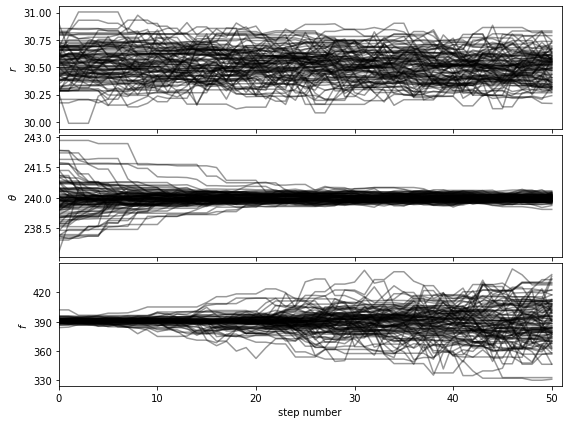

51		13.80158			6183.10739
52		11.45818			5121.80422
53		12.10560			5399.09849
54		12.82082			5705.26312
55		13.79821			6126.40568
56		13.27721			5881.80447
57		14.02395			6198.58413
58		12.34930			5446.03954
59		12.11253			5329.51496
60		13.34094			5856.67398
61		11.52018			5045.83928
62		11.36875			4968.14331
63		13.62982			5942.59934
64		12.06230			5247.10224
65		12.11717			5258.85221
66		13.54862			5866.55333
67		14.09938			6090.93173
68		13.72444			5915.23536
69		12.53554			5390.28091
70		14.54401			6239.38201
71		15.11605			6469.67111
72		14.43513			6163.80008
73		13.84664			5898.66821
74		13.06975			5554.64545
75		12.19678			5171.43557
76		12.75501			5395.36881
77		12.73661			5374.84773
78		12.78560			5382.73844
79		12.50871			5253.65652
80		11.14502			4669.76506
81		11.98824			5011.08641
82		13.33881			5562.28502
83		14.49565			6030.18998
84		13.71511			5691.77189
85		14.48491			5996.75108
86		12.45843			5145.33324
87		14.53392			5987.97545
88		12.37068			5084.34866
89		12.14173

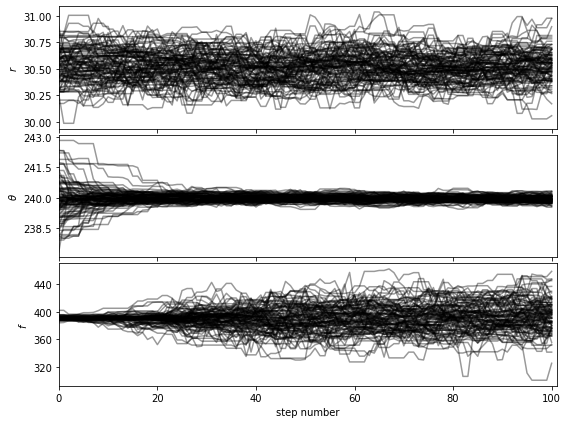

101		12.39195			4931.99809
102		13.86856			5505.81832
103		13.58036			5377.82375
104		14.12474			5579.27230
105		10.26984			4046.31735
106		12.66905			4978.93665
107		11.42921			4480.25110
108		12.62329			4935.70561
109		12.40855			4839.33450
110		13.93208			5419.57951
111		15.33792			5951.11102
112		11.24721			4352.66911
113		11.97612			4622.78425
114		12.28259			4728.79792
115		12.78354			4908.87859
116		14.62067			5599.71699
117		15.12963			5779.51904
118		11.84374			4512.46532
119		10.01287			3804.88984
120		11.58251			4389.76977
121		12.51217			4729.60139
122		12.41642			4680.99109
123		12.32205			4633.09080
124		11.85596			4445.98687
125		11.32905			4237.06470
126		13.76289			5133.55722
127		11.60846			4318.34861
128		10.95424			4064.02378
129		10.46105			3870.58887
130		11.74351			4333.35667
131		11.41940			4202.33957
132		9.85611			3617.19090
133		11.32214			4143.90178
134		12.68642			4630.54403
135		9.95404			3623.27056
136		8.84692			3211.43123
137		10.09993			3656.17430
138	

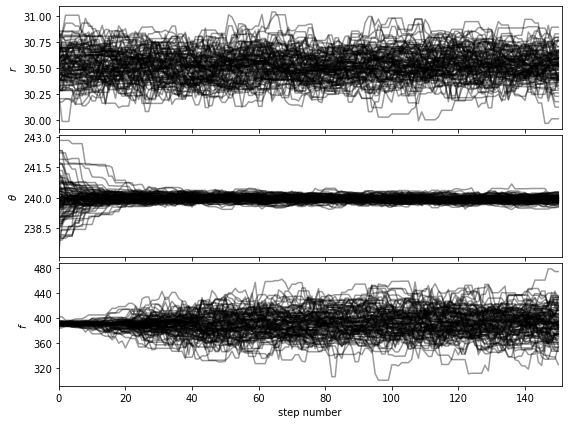

151		11.38390			3961.59616
152		15.56073			5399.57192
153		12.64034			4373.55764
154		11.83285			4082.33187
155		12.33792			4244.24276
156		13.24698			4543.71483
157		13.66375			4673.00284
158		14.18554			4837.26812
159		13.27231			4512.58540
160		12.58660			4266.85808
161		11.44169			3867.29122
162		13.36125			4502.74058
163		10.81716			3634.56442
164		12.47861			4180.33602
165		12.68858			4237.98672
166		14.02125			4669.07658
167		11.68540			3879.55280
168		11.87335			3930.07984
169		11.14268			3677.08440
170		12.24402			4028.28324
171		12.68293			4160.00071
172		11.02519			3605.23582
173		12.08882			3940.95467
174		10.34110			3360.85718
175		13.01762			4217.70823
176		12.80372			4135.60091
177		13.22071			4257.06959
178		10.14952			3257.99624
179		9.52524			3048.07776
180		11.52325			3675.91643
181		10.65470			3388.19587
182		11.45679			3631.80370
183		13.99385			4422.05818
184		13.99976			4409.92283
185		13.69523			4300.30222
186		9.61852			3010.59770
187		13.58361			4238.08538
188

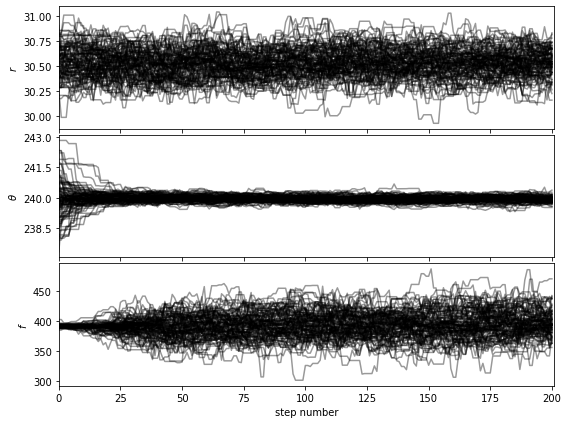

Auto-corr tau/N = [0.06913322 0.06600388 0.07112231]
tau/N <= 0.02 = [False False False] 

201		17.44388			5198.27654
202		12.63840			3753.60361
203		11.39442			3372.74891
204		11.99316			3537.98131
205		13.50853			3971.50841
206		11.60505			3400.28082
207		12.72350			3715.26112
208		15.65490			4555.57648
209		12.63240			3663.39513
210		13.95913			4034.18741
211		13.12040			3778.67462
212		15.65239			4492.23478
213		11.30234			3232.46924
214		10.65700			3037.24528
215		11.85238			3366.07478
216		12.12898			3432.50106
217		12.17479			3433.29022
218		13.67327			3842.18859
219		13.32932			3732.20848
220		12.35591			3447.30028
221		11.75598			3268.16355
222		15.76508			4366.92799
223		12.22737			3374.75357
224		13.74543			3779.99325
225		10.74513			2944.16452
226		11.38591			3108.35370
227		14.30459			3890.84957
228		12.72485			3448.43381
229		12.44143			3359.18637
230		12.80071			3443.38965
231		10.00398			2681.06584
232		13.40560			3579.29493
233		12.12503			3225.25904
234		12.42624			32

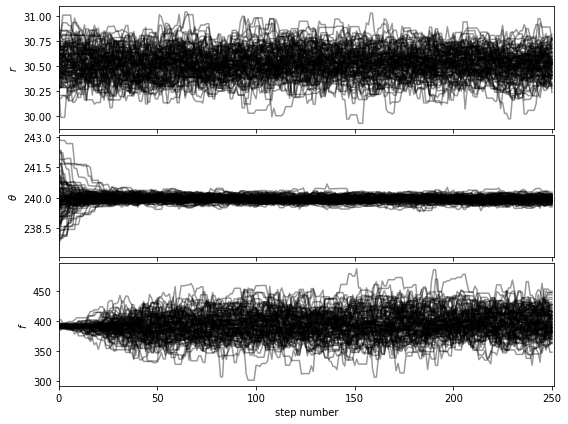

Auto-corr tau/N = [0.0643833  0.05798061 0.06584541]
tau/N <= 0.02 = [False False False] 

251		12.29088			3048.13849
252		13.62133			3364.46851
253		12.53374			3083.29955
254		10.80309			2646.75754
255		13.07379			3190.00549
256		12.55632			3051.18649
257		11.57796			2801.86608
258		10.51008			2532.92976
259		14.50942			3482.26080
260		11.98987			2865.57797
261		11.00583			2619.38754
262		12.40564			2940.13549
263		12.59365			2972.10234
264		12.64212			2970.89914
265		12.32763			2884.66565
266		11.57991			2698.11810
267		10.48522			2432.57197
268		11.46373			2648.12163
269		14.69134			3379.00797
270		12.06531			2762.95530
271		12.80215			2918.89020
272		14.52453			3297.06718
273		10.66069			2409.31549
274		12.18144			2740.82333
275		11.96140			2679.35450
276		12.88422			2873.18128
277		12.66272			2811.12273
278		15.61576			3451.08230
279		12.65020			2783.04378
280		12.96092			2838.44060
281		13.19516			2876.54553
282		12.37540			2685.46115
283		12.30199			2657.23006
284		13.65551			29

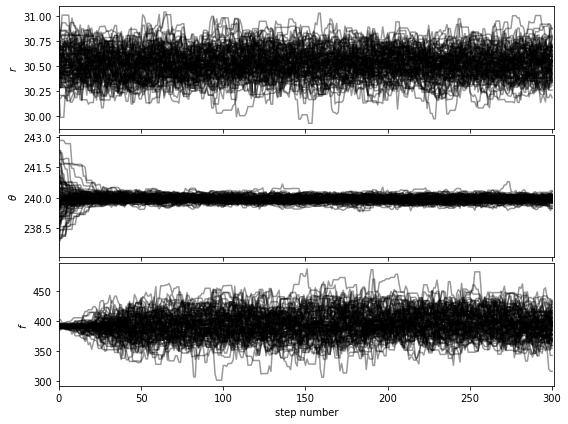

Auto-corr tau/N = [0.05937104 0.05231333 0.0641276 ]
tau/N <= 0.02 = [False False False] 

301		11.17429			2212.50863
302		11.40925			2247.62186
303		11.37402			2229.30753
304		12.14712			2368.68781
305		11.19431			2171.69711
306		11.96280			2308.82040
307		7.67732			1474.04525
308		10.60533			2025.61841
309		11.80823			2243.56313
310		12.82833			2424.55456
311		8.54632			1606.70797
312		11.11173			2077.89388
313		11.20221			2083.61087
314		11.86401			2194.84259
315		11.75041			2162.07507
316		9.65819			1767.44804
317		9.91038			1803.68843
318		9.86326			1785.25024
319		11.92356			2146.24152
320		10.79895			1933.01259
321		12.65679			2252.90862
322		13.37177			2366.80311
323		10.63216			1871.26051
324		10.58754			1852.81985
325		10.56264			1837.89901
326		10.95860			1895.83728
327		12.46961			2144.77258
328		12.23160			2091.60275
329		10.86759			1847.49013
330		11.30052			1909.78788
331		11.50649			1933.08965
332		11.22683			1874.88011
333		10.75474			1785.28684
334		11.68756			1928.44

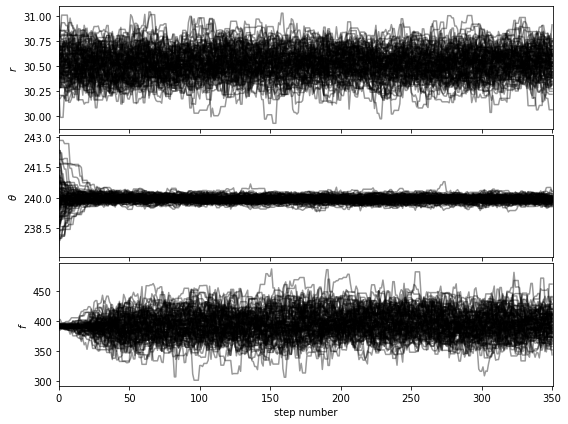

Auto-corr tau/N = [0.05493292 0.04935063 0.06257839]
tau/N <= 0.02 = [False False False] 

351		14.19381			2100.68344
352		13.96034			2052.17042
353		16.08898			2348.99079
354		10.98397			1592.67609
355		10.44322			1503.82426
356		13.51194			1932.20742
357		12.34568			1753.08727
358		15.23748			2148.48510
359		16.46384			2304.93788
360		13.53283			1881.06337
361		13.30954			1836.71680
362		12.58955			1724.76808
363		12.18167			1656.70644
364		11.77735			1589.94158
365		10.67362			1430.26468
366		13.09133			1741.14742
367		10.97154			1448.24381
368		11.43379			1497.82610
369		9.78722			1272.33912
370		11.40517			1471.26641
371		9.25018			1184.02317
372		10.35159			1314.65218
373		10.91767			1375.62667
374		13.72955			1716.19350
375		12.30375			1525.66463
376		12.44281			1530.46600
377		10.96490			1337.71780
378		12.30335			1488.70547
379		11.00680			1320.81552
380		11.71548			1394.14260
381		10.60363			1251.22881
382		10.23280			1197.23783
383		9.73559			1129.32890
384		11.23646			1292.

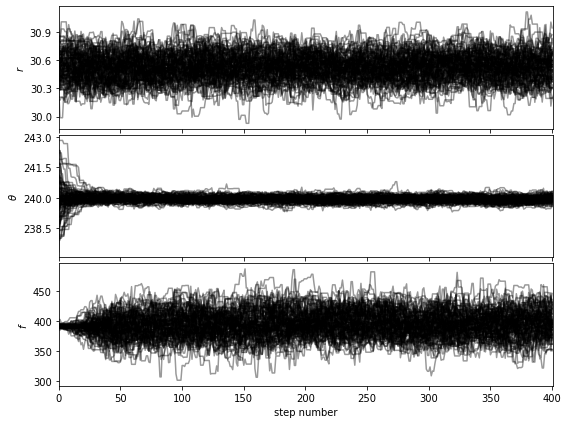

Auto-corr tau/N = [0.05290991 0.04642863 0.0563545 ]
tau/N <= 0.02 = [False False False] 

401		14.65832			1436.51526
402		12.35285			1198.22616
403		9.19046			882.28406
404		13.01609			1236.52855
405		11.57920			1088.44499
406		11.61579			1080.26828
407		10.59075			974.34909
408		11.49856			1046.36869
409		10.91053			981.94788
410		10.92124			971.99072
411		11.71786			1031.17186
412		11.14459			969.57907
413		11.11408			955.81062
414		10.53013			895.06088
415		10.13548			851.38015
416		10.43893			866.43102
417		11.62448			953.20703
418		10.65065			862.70297
419		10.52838			842.27016
420		13.46057			1063.38479
421		11.00276			858.21505
422		11.27312			868.02993
423		11.19169			850.56874
424		11.19018			839.26343
425		10.14864			750.99906
426		11.47590			837.74041
427		10.48874			755.18957
428		9.84860			699.25032
429		12.96932			907.85219
430		12.52064			863.92395
431		12.71413			864.56077
432		10.52983			705.49848
433		10.13297			668.77582
434		9.98162			648.80511
435		10.96640			701.

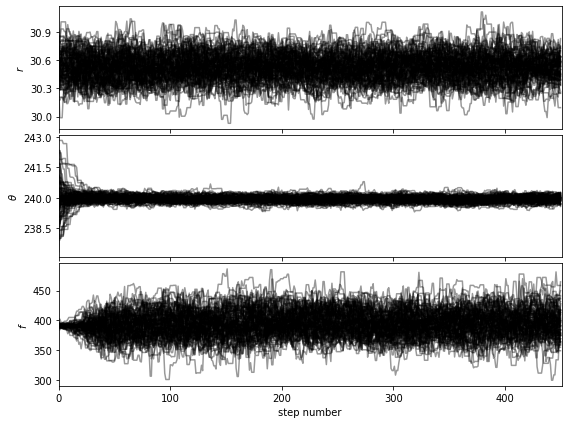

Auto-corr tau/N = [0.05053539 0.0417978  0.05107732]
tau/N <= 0.02 = [False False False] 

451		13.32312			639.50962
452		12.47140			586.15589
453		12.51246			575.57325
454		10.74491			483.52100
455		12.04684			530.06096
456		10.94684			470.71429
457		11.18452			469.74980
458		10.64325			436.37309
459		11.83623			473.44908
460		11.10876			433.24176
461		12.25600			465.72815
462		9.43310			349.02466
463		11.40703			410.65297
464		11.03788			386.32580
465		11.84369			402.68546
466		10.68132			352.48349
467		12.86388			411.64426
468		10.61039			328.92200
469		11.55617			346.68498
470		11.06751			320.95779
471		10.57024			295.96686
472		11.77527			317.93232
473		11.51177			299.30607
474		12.34515			308.62865
475		10.55238			253.25702
476		10.79646			248.31869
477		10.47298			230.40560
478		11.47246			240.92164
479		10.89415			217.88302
480		8.38655			159.34443
481		12.34183			222.15296
482		10.73357			182.47067
483		12.44007			199.04106
484		10.00178			150.02673
485		12.10932			169.53052
4

In [34]:
chain = mcmc_negfc_sampling(cubefc, angs, **obs_params, **algo_params, **negfc_params, 
                            initial_state=initial_state, **mcmc_params, **conv_params,
                            display=True, verbosity=2, save=False, output_dir='./')

If you ran the previous box and wish to write your results, set `write=True` in the next box. This will pickle the MCMC chain.

In [35]:
write=False

if write:
    import pickle
    output = {'chain':chain}
    with open('../datasets/my_MCMC_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Note that an alternative to the box above, is to provide `output_dir` in the call to `mcmc_negfc_sampling` and set `save` to True. This will save the results as a pickle including additional keys: apart from 'chain', it will also save 'input_parameters', 'AR' (acceptance ratio), and 'lnprobability'.

Pickled results can be loaded from disk like this:

In [36]:
import pickle
with open('../datasets/MCMC_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    mcmc_result = myPickler.load()

print(mcmc_result.keys())
chain = mcmc_result['chain']

dict_keys(['chain', 'input_parameters', 'AR', 'lnprobability'])


The most accurate approach would involve setting a large enough maximum number of iterations and using FFT-based rotation for PCA. The latter in particular, may change a bit the most likely parameter values given the better flux conservation. However, these changes would involve over ~3 orders of magnitude longer calculation time. It is therefore intractable for a personal laptop and not shown in this notebook. If you have access to a supercomputer feel free to adopt these changes though. The results after 500 iterations are nonetheless good enough for illustrative purpose:

#### 5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots 

Let's first check that the walk plots look ok:

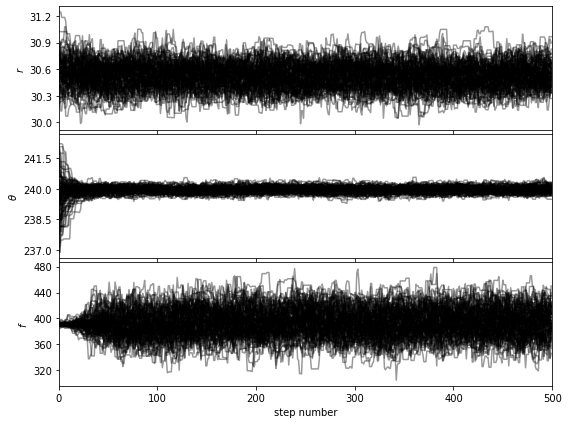

In [37]:
show_walk_plot(chain)

Then based on the walk plot, let's burn-in the first 30% of the chain, to calculate the corner plots:

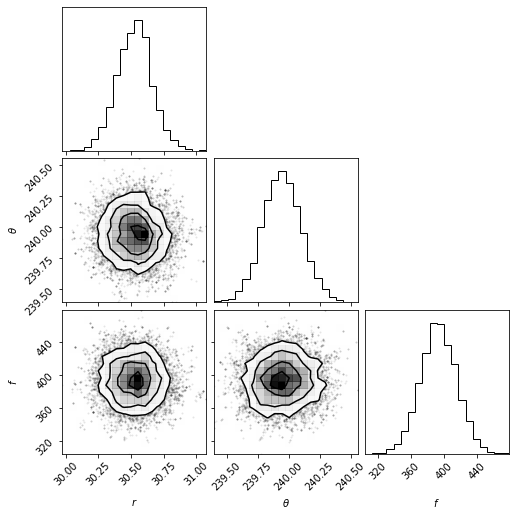

In [38]:
burnin = 0.3
burned_chain = chain[:, int(chain.shape[1]//(1/burnin)):, :]
show_corner_plot(burned_chain)

For the purpose of this tutorial and to limit computation time we set the maximum number of iterations to 500 for 100 walkers. The look of the corner plots may improve with more samples (i.e. higher number of iterations, for a given burn-in ratio). This can be tested by setting the max. number of iterations arbitrarily high for the autocorrelation-time convergence criterion to be met.

#### 5.3.3.3. Highly probable values and confidence intervals 

Now let's determine the most highly probable value for each model parameter, as well as the 1-sigma confidence interval. For this, let's first flatten the chains:

In [39]:
isamples_flat = chain[:, int(chain.shape[1]//(1/burnin)):, :].reshape((-1,3))

Then use the `confidence` function:

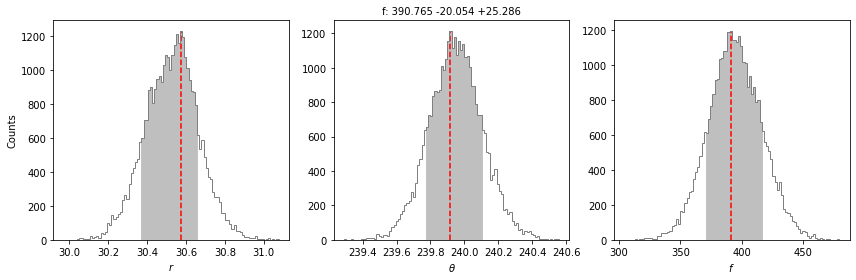

In [40]:
val_max, conf = confidence(isamples_flat, cfd=68, gaussian_fit=False,
                           verbose=False, save=False, title=True)

Using the `confidence` function with the `gaussian_fit=True` option, it is possible to fit a Gaussian to the posterior distribution of each parameter, and infer associated uncertainty values.

percentage for r: 69.79202279202278%
percentage for $\theta$: 69.02279202279202%
percentage for flux: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
flux: 390.7650582608513 [-20.054061636888093,25.285555976945886]

Gaussian fit results:
r: 30.525747462344565 +-0.13676103149725966
theta: 239.94793373875024 +-0.15744912409220196
f: 394.1338634773366 +-21.669634439677626


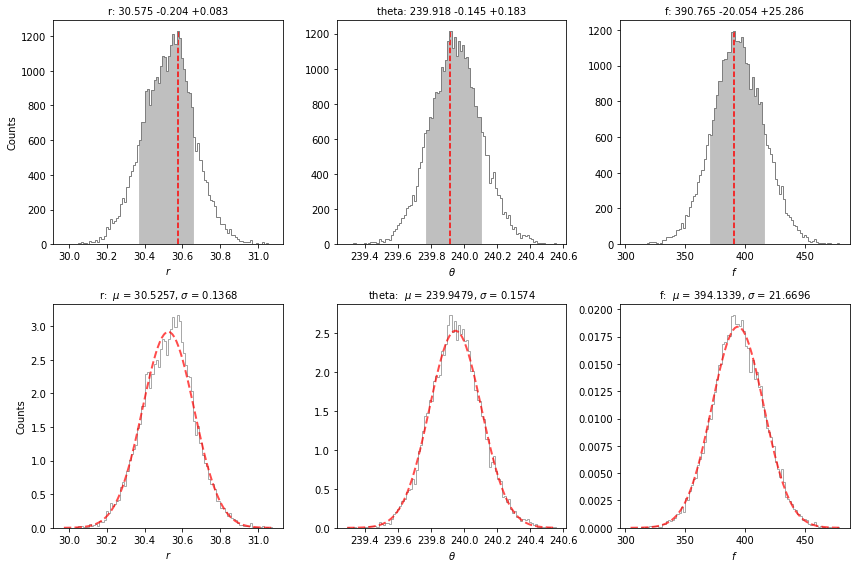

In [41]:
mu, sigma = confidence(isamples_flat, cfd=68, gaussian_fit=True, 
                       verbose=True, save=False, title=True)

It is recommended to report the results as confidence intervals (i.e. with possibly asymmetric uncertainties) as long as the bin interval is small enough. Here, we also fitted the residual posterior distribution of each parameter to a Gaussian distribution (this shape is the expected one if the noise has been well whitened, but is not necessarily guaranteed at all separations depending on the adopted $n_{\rm pc}$). In case, these distributions look Gaussian, the inferred $\sigma$ value may be a more accurate uncertainty value for the different parameters.

We can see that the confidence intervals inferred by NEGFC for the different parameters encompass the ground truth values used for injection (in particular for the flux). 

Note that depending on your choice of `mu_sigma`, you may have to calculate separately another source of uncertainty. Indeed, with the original expression for $\chi^2$ (Wertz et al. 2017; `mu_sigma=False`), only the uncertainty associated to *photon noise* was reflected in the MCMC results. With the new expression (`mu_sigma=True`), the $\chi^2$ expression also takes into account the *residual speckle noise* at the radial separation of the companion candidate. Our tests suggest that similar final uncertainties can be obtained in either of these 2 ways:
- the uncertainties obtained with MCMC when setting `mu_sigma=True`;
- the uncertainties obtained by combining quadratically the uncertainties obtained with MCMC (setting `mu_sigma=False` and `fm = 'sum'`), and the residual speckle uncertainties inferred as in [Sec. 5.3.4](#5.3.4.-Residual-speckle-uncertainty) (Wertz et al. 2017).

[Go to the top](#Table-of-contents)

### 5.3.4. Residual speckle uncertainty

**Only needed if using `mu_sigma=False` in your call to mcmc_negfc_sampling!**

Residual speckle noise can also bias the best parameter estimates found for the companion (if not taken into account in the MCMC).
To evaluate the uncertainty associated to this additional source of noise, it is recommended to inject a large number of fake companions at the same radius and flux as estimated for the true companion but different azimuths, and then estimate their parameters using simplex-NEGFC. The distribution of differences with respect to injected parameters can then give us an idea of the *residual speckle noise uncertainty*. This is done in VIP with the `speckle_noise_uncertainty` function (see also Sec. 3.3 in Wertz et al. 2017 for more details).

Let's use the planet parameters inferred by the MCMC-NEGFC algorithm:

In [42]:
pl_par = (val_max['r'],val_max['theta'],val_max['f'])
pl_par

(30.57489764243517, 239.91771004343246, 390.7650582608513)


#######################################################
###            SPECKLE NOISE DETERMINATION          ###
#######################################################

Number of steps: 360

Process is running for angle: 0.00
Process is running for angle: 45.00
Process is running for angle: 46.00
Process is running for angle: 1.00
Process is running for angle: 47.00
Process is running for angle: 2.00
Process is running for angle: 48.00
Process is running for angle: 3.00
Process is running for angle: 49.00
Process is running for angle: 4.00
Process is running for angle: 5.00
Process is running for angle: 50.00
Process is running for angle: 51.00
Process is running for angle: 6.00
Process is running for angle: 52.00
Process is running for angle: 7.00
Process is running for angle: 53.00
Process is running for angle: 8.00
Process is running for angle: 54.00
Process is running for angle: 9.00
Process is running for angle: 55.00
Process is running for angle: 10.00
Process is running for ang

percentage for flux: 68.61111111111111%


Confidence intervals:
r: -0.0033044539061117817 [-0.08576531591702885,0.07759719059159753]
theta: -0.009390368768118645 [-0.07608071764507922,0.07608071764507922]
flux: -1.4774198887304033 [-8.473394238771078,12.23934723378045]

Gaussian fit results:
r: -0.005236136308737945 +-0.053509389705445574
theta: -0.0013773706636567363 +-0.0737663261834286
f: -0.20587459125644883 +-10.64773837027693


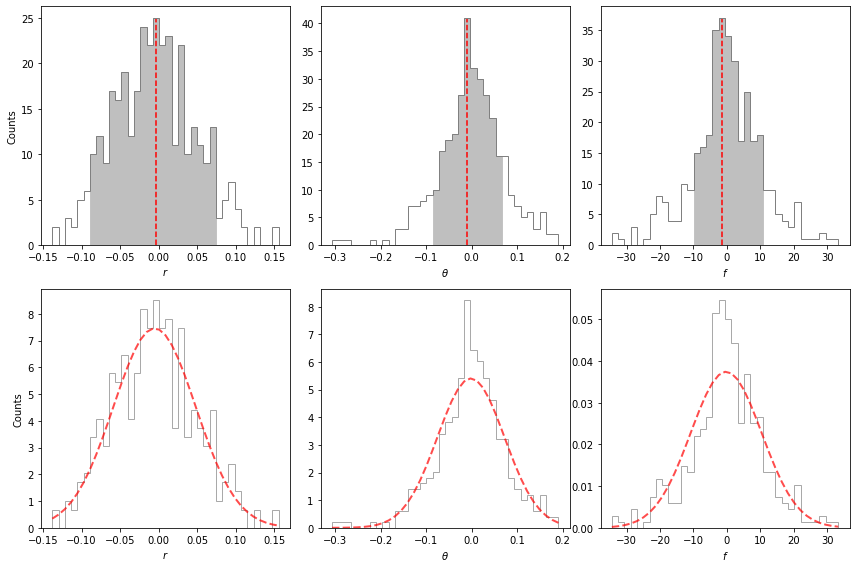

In [44]:
algo_options={'ncomp':opt_npc_ann, 'annulus_width':4*fwhm_naco, 'imlib':imlib_rot, 
              'interpolation':interpolation}
speckle_res = speckle_noise_uncertainty(cubefc, pl_par, np.linspace(0,359,360), angs, pca_annulus, 
                                        psfn, pxscale_naco, fwhm_naco, aperture_radius=2, fmerit='sum', 
                                        algo_options=algo_options, transmission=None, mu_sigma=None, 
                                        wedge=None, weights=None, force_rPA=False, nproc=2, 
                                        simplex_options=None, bins=None, save=False, output=None, 
                                        verbose=True, full_output=True, plot=True)

Again, if you wish to write the result (to avoid having to run the previous box again), just set `write=True`. This will pickle the result:

In [45]:
write=False

if write:
    output = {'speckle_res':speckle_res}
    with open('../datasets/my_speckle_residuals_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Load pickled results from disk:

In [46]:
with open('../datasets/speckle_residuals_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    sp_unc_result = myPickler.load()

print(sp_unc_result.keys())

speckle_res = sp_unc_result['speckle_res']
sp_unc, mean_dev, p_simplex, offset, chi2, nit, success = speckle_res

dict_keys(['speckle_res'])


The speckle uncertainty associated to each parameter is contained in `sp_unc` which corresponds to the 1$\sigma$ width of a Gaussian distribution fitted to the `offset` distribution (i.e. the differences with respect to injected ground truths):

In [47]:
sp_unc

array([ 0.05350939,  0.07376633, 10.64773837])

For comparison, the uncertainties found by the MCMC procedure were:

In [48]:
sigma

array([ 0.13676103,  0.15744912, 21.66963444])

[Go to the top](#Table-of-contents)

### 5.3.5. Final uncertainties

The final uncertainties on the planet parameters should include both **statistical** and **systematic** uncertainties. 
The former include both the *photon noise* and *residual speckle noise* uncertainties discussed above. 
The latter include both the uncertainty on the *star location* (which may be non-negligible when using a coronagraph) and *instrumental calibration errors*, including:
- the uncertainty on the plate scale (for $r$, when converting to angular separation) - note that it is proportional to the radial separation itself;
- the uncertainty on the PA of true north (for $\theta$).

The uncertainty on the star location is of the order of 0.3px in individual NACO+AGPM images (this is the typical precision by manual recentering during the observation). Given the shift plots in `Tutorial 2`, it appears the autocorrelation timescale is of the order of ~5 frames. Therefore, considering that there are 61 frames in the datacube, the uncertainty on the star location in the final combined image must be roughly:

In [49]:
cen_unc_indiv = 0.3 #px
cen_unc = cen_unc_indiv/np.sqrt(61/5) #px
cen_unc

0.08588975014708022

The latter can be translated into an uncertainty on $\theta$ by division by the radial separation of the companion. The stellar centering uncertainties on each planet parameter can thus be expressed as:

In [50]:
star_unc = np.array([cen_unc*pxscale_naco, 
                     np.rad2deg(cen_unc/val_max['r']), 
                     0]) # uncertainty on each of the 3 parameters due to stellar centering

where the multiplication by `pxscale_naco` has converted the radial separation in arcsec.

For the instrumental calibration errors, we adopt the values quoted in Absil et al. (2013). Note that the uncertainty related to the plate scale is directly proportional to the radial separation of the companion.

In [51]:
dr_unc = 0.00004 # plate scale uncertainty in arcsec per px
tn_unc = 0.09    # deg
syst_unc = np.array([val_max['r']*dr_unc, 
                     tn_unc, 
                     0])

The final uncertainties are then the different sources of uncertainty added quadratically - after conversion of the radial separation to arcsec:

In [52]:
sigma[0] *= pxscale_naco
sp_unc[0] *= pxscale_naco

if mu_sigma:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(star_unc,2) + np.power(syst_unc,2))
else:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(sp_unc,2) + np.power(star_unc,2) + np.power(syst_unc,2))

In [53]:
msg = "The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(val_max['r']*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 val_max['theta'], final_unc[1], theta_fc,
                 val_max['f'], final_unc[2], flux_fc))

The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 831.33+-4.56 mas (GT: 829.29 mas), 
PA = 239.92+-0.24 deg (GT: 240.00 deg) 
f = 390.77+-21.67 ADUs (GT: 400.00 ADUs)


[Go to the top](#Table-of-contents)